## Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision import datasets, transforms

In [2]:
from lstm import LSTM
from ddpm import UNET, inference
from grayscott import GrayScott, laplacian
from training import train_lstm, train_ddpm
from constants import *

## Device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## LSTM Dataset

In [4]:
def create_sine_dataset(samples=100, seq_len=50):
    data = []
    for _ in range(samples):
        # Random frequency and phase to make it robust
        freq = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        t = np.linspace(0, 10, seq_len)
        
        # Signal = Sine + slight noise
        signal = np.sin(freq * t + phase) + 0.05 * np.random.randn(seq_len)
        data.append(signal)
    
    # Shape: [Batch, Seq_Len, Input_Size=1]
    return torch.FloatTensor(np.array(data)).unsqueeze(2)

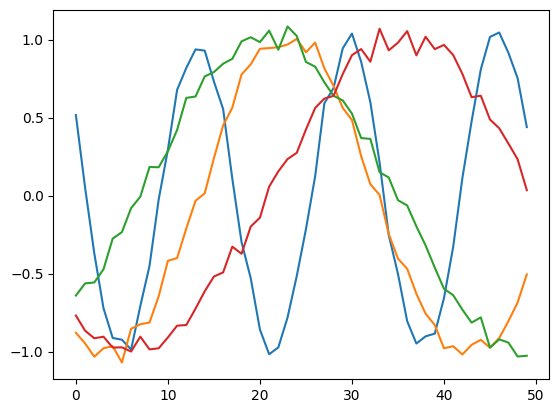

In [6]:
samples = create_sine_dataset(100,50)
samples.size()
for _ in range(4):
    rand_index = random.randint(0, 100)
    plt.plot(samples[rand_index,:,0])

In [7]:
def create_lorenz_dataset(samples=100, seq_len=100, dt=0.01):
    """
    Generates chaotic time series data from the Lorenz Attractor.
    """
    data = []
    # Lorenz Parameters
    sigma, rho, beta = 10.0, 28.0, 8.0/3.0
    
    for _ in range(samples):
        # Random start state
        state = np.random.randn(3)
        sequence = []
        
        for _ in range(seq_len):
            x, y, z = state
            # Euler Integration
            dx = sigma * (y - x)
            dy = x * (rho - z) - y
            dz = x * y - beta * z
            
            state = state + np.array([dx, dy, dz]) * dt
            # We only use the 'x' dimension for the 1D LSTM task
            sequence.append(state[0])
            
        data.append(sequence)
    
    # Normalize to [-1, 1] for LSTM stability
    data = np.array(data)
    data = (data - np.mean(data)) / np.std(data)
    
    return torch.FloatTensor(data).unsqueeze(2) # [Batch, Seq, 1]

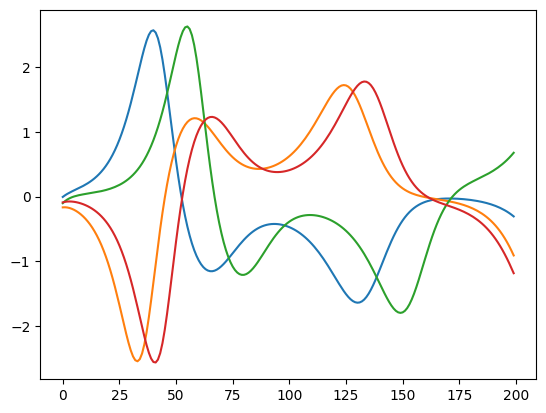

In [13]:
samples_lorenz = create_lorenz_dataset(100, 200, 0.01)
samples_lorenz.size()
for _ in range(4):
    rand_index = random.randint(0, 100)
    plt.plot(samples_lorenz[rand_index,:,0])

## LSTM Training

In [67]:
n_samples = 1000
seq_len = 50
n_epochs = 200

In [68]:
lstm_data = create_sine_dataset(samples=n_samples, seq_len=seq_len)
lstm_data = create_lorenz_dataset(samples=n_samples, seq_len=seq_len)
lstm_data = lstm_data.to(device)

lstm_model = LSTM(input_size=1, hidden_size=16).to(device)

--- Training LSTM on cpu ---
Epoch 0: Loss 0.91791
Epoch 10: Loss 0.33624
Epoch 20: Loss 0.08582
Epoch 30: Loss 0.04052
Epoch 40: Loss 0.01597
Epoch 50: Loss 0.00688
Epoch 60: Loss 0.00407
Epoch 70: Loss 0.00268
Epoch 80: Loss 0.00188
Epoch 90: Loss 0.00149
Epoch 100: Loss 0.00123
Epoch 110: Loss 0.00104
Epoch 120: Loss 0.00089
Epoch 130: Loss 0.00079
Epoch 140: Loss 0.00072
Epoch 150: Loss 0.00066
Epoch 160: Loss 0.00061
Epoch 170: Loss 0.00057
Epoch 180: Loss 0.00053
Epoch 190: Loss 0.00050


Text(0.5, 0, 'epoch')

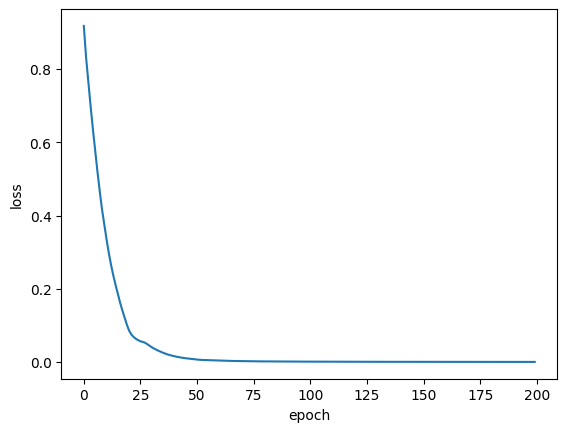

In [69]:
loss_lstm = train_lstm(lstm_model, lstm_data, num_epochs=n_epochs, lr=1e-2, device=device)

plt.plot(loss_lstm)
plt.ylabel("loss")
plt.xlabel("epoch")

Seed shape: torch.Size([50, 1])
Seed values: tensor([[-0.1468],
        [-0.1472],
        [-0.1508],
        [-0.1572],
        [-0.1662]])
Generated shape: torch.Size([400, 1])
Generated values: tensor([[-0.1165],
        [-0.2329],
        [-0.2913],
        [-0.2936],
        [-0.2804]])


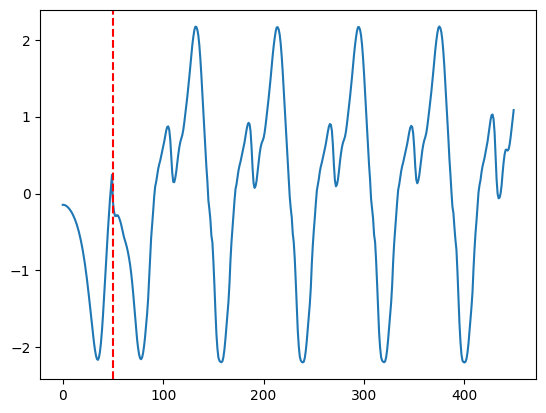

In [74]:
rand_index = random.randint(0, n_samples)
seed_sample = lstm_data[rand_index]

future_steps = 2*200
generated, history_generated = lstm_model.generate_sequence(seed_sample, future_steps=future_steps)

print(f"Seed shape: {seed_sample.shape}")
print(f"Seed values: {seed_sample[:5]}")
print(f"Generated shape: {generated.shape}")
print(f"Generated values: {generated[:5]}")

plt.plot(torch.cat((seed_sample.to("cpu"), generated.to("cpu"))))
plt.axvline(x=seq_len, color='red', linestyle='--')

## LSTM Visualization

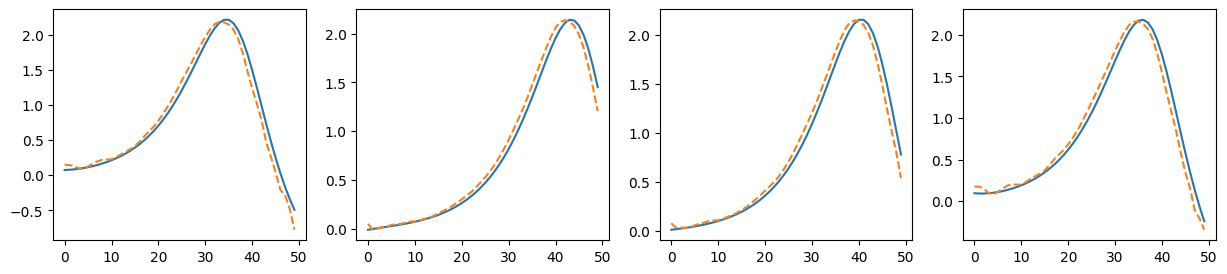

In [76]:
lstm_out, history_lstm = lstm_model(lstm_data)
fig, ax = plt.subplots(1,4, figsize=(15,3))
for i in range(4):
    rand_index = random.randint(0,n_samples)
    ax[i].plot(lstm_data[rand_index,:,0].to("cpu").detach().numpy(), label="true data")
    ax[i].plot(lstm_out[rand_index,:,0].to("cpu").detach().numpy(), linestyle="--", label="lstm output")

plt.show()

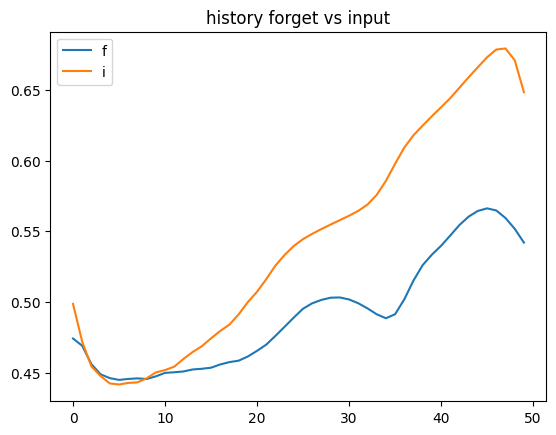

In [77]:
rand_index = random.randint(0,n_samples)
forget = [[t[rand_index, d].item() for t in history_lstm["forget"]] for d in range(16)]
input = [[t[rand_index, d].item() for t in history_lstm["input"]] for d in range(16)]

def mean_forget(forget):
    l = []
    s = 0
    for j in range(seq_len):
        for i in range(16):
            s += forget[i][j]
        l.append(s/16)
        s=0
    return l
forget_mean = mean_forget(forget)
input_mean = mean_forget(input)
plt.plot(forget_mean, label="f")
plt.plot(input_mean, label="i")
plt.title("history forget vs input")
plt.legend()
plt.show()

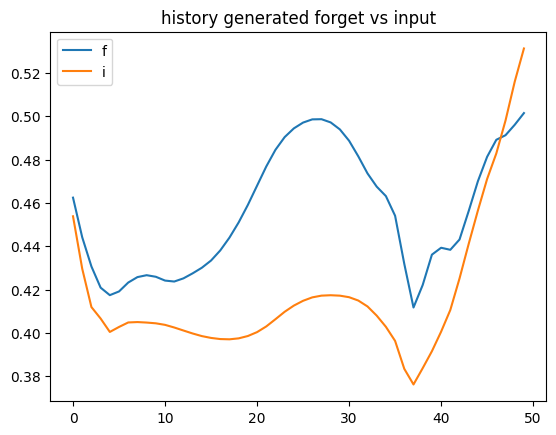

In [78]:
forget = [[t[0, d].item() for t in history_generated["forget"]] for d in range(16)]
input = [[t[0, d].item() for t in history_generated["input"]] for d in range(16)]

def mean_forget(forget):
    l = []
    s = 0
    for j in range(seq_len):
        for i in range(16):
            s += forget[i][j]
        l.append(s/16)
        s=0
    return l
forget_mean = mean_forget(forget)
input_mean = mean_forget(input)
plt.plot(forget_mean, label="f")
plt.plot(input_mean, label="i")
plt.title("history generated forget vs input")
plt.legend()
plt.show()

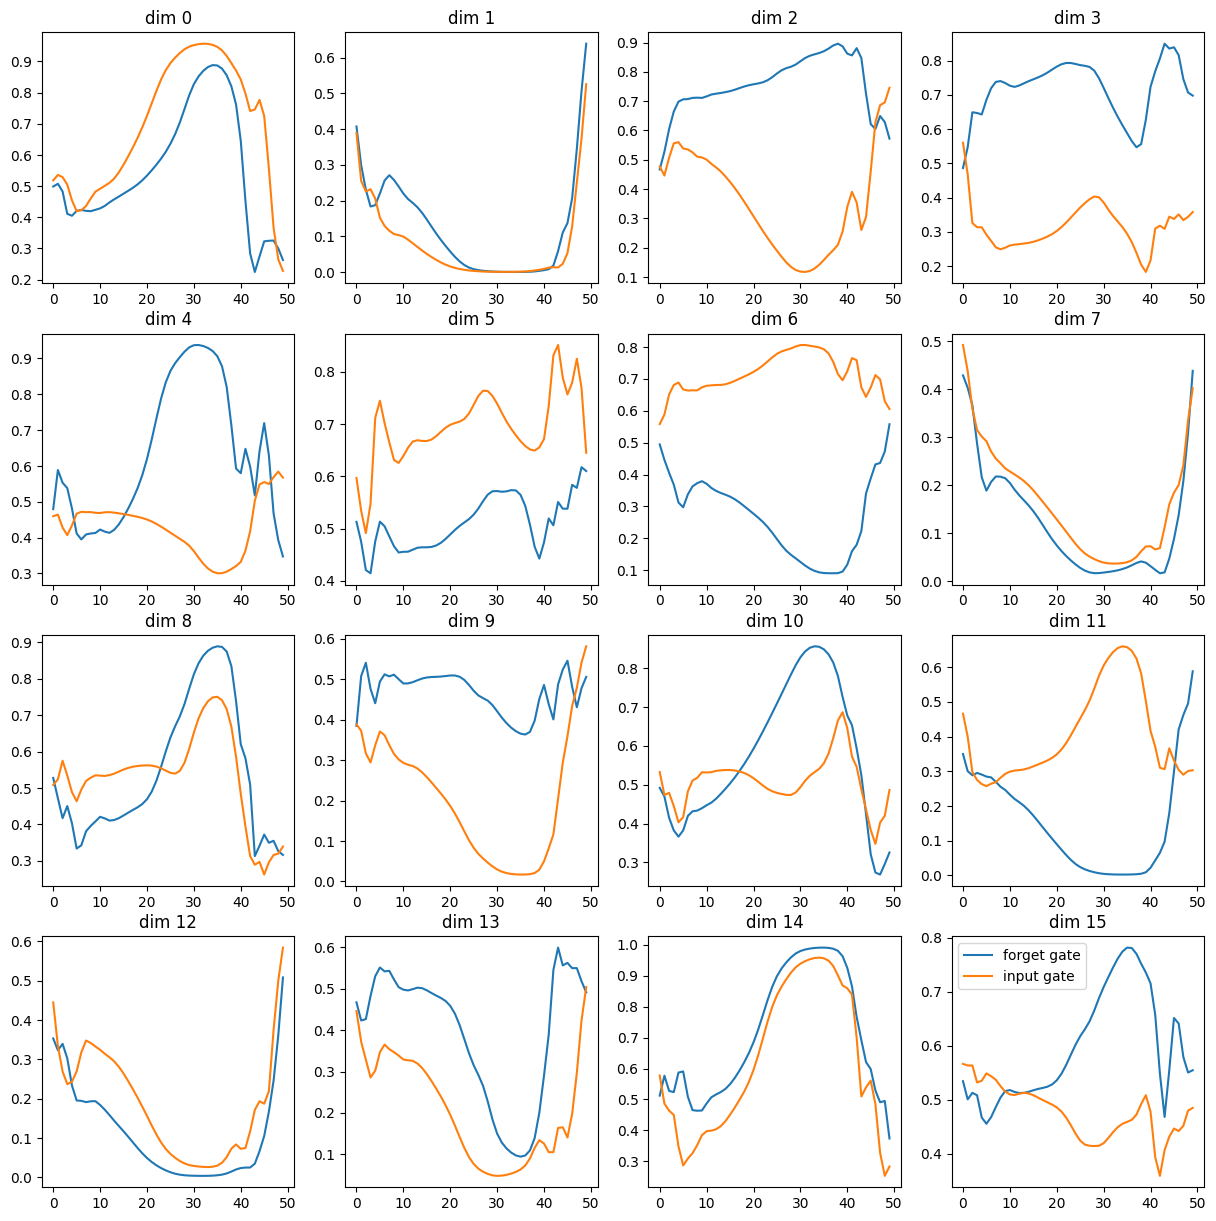

In [79]:
fig, ax = plt.subplots(4,4, figsize=(15,15))

rand_sample = random.randint(0,100)
forget_gate = [[t[rand_sample, d].item() for t in history_lstm["forget"]] for d in range(16)]
input_gate = [[t[rand_sample, d].item() for t in history_lstm["input"]] for d in range(16)]

for i in range(4):
    for j in range(4):
        ax[i,j].plot(forget_gate[4*i+j], label="forget gate")
        ax[i,j].plot(input_gate[4*i+j], label="input gate")
        ax[i,j].set_title(f"dim {4*i+j}")

plt.legend()
plt.show()

## DDPM Training

In [15]:
n_epoch = 5
batch_size = 128
n_T = 1000

In [ ]:
train_dataset_mnist = datasets.MNIST(root='./data', train=True, download=True,transform=transforms.ToTensor())
train_dataset_cifar = datasets.CIFAR10((root='./data', train=True, download=True,transform=transforms.ToTensor()))
ddpm_model = UNET(Channels=[32, 64, 128, 256, 256, 192],          # Much smaller
                  Attentions=[False, True, False, False, True, False], # Keep attention sparse
                  Upscales=[False, False, False, True, True, True],
                  num_groups=8  # Reduce groups since channels are smaller
              ).to(device)

In [ ]:
losses = train_ddpm(model=ddpm_model, data=train_dataset_mnist, batch_size=batch_size,num_time_steps=n_T, lr=2e-5, num_epochs=n_epoch, device=device, dataset_size=128)

plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("epoch")

Starting inference on cpu with 1000 steps...


999it [00:37, 26.78it/s]


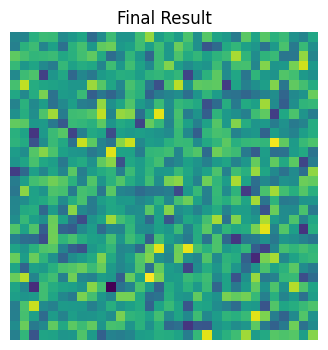

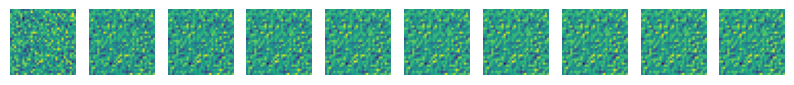

In [18]:
history_ddpm = inference(ddpm_model=ddpm_model, num_time_steps=n_T)

Starting inference on cpu with 1000 steps...


999it [00:43, 22.73it/s]


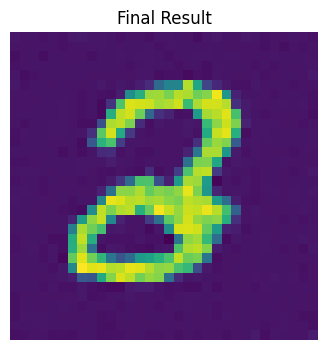

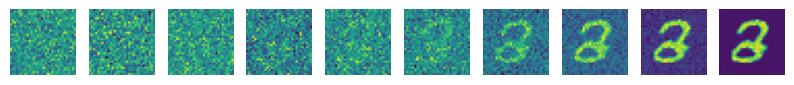

In [84]:
history_ddpm = inference(ddpm_model=ddpm_model, checkpoint_path="checkpoints/ddpm_checkpoint_mnist", num_time_steps=n_T)

In [20]:
history_ddpm["drift"][0].shape

(1, 1, 32, 32)

## Comparison

Starting Parameter Sweep over F (k=0.062)...


 45%|████▌     | 9/20 [00:03<00:03,  3.31it/s]/home/vincentlo/lstm-ddpm/src/grayscott.py:96: RuntimeWarning: overflow encountered in multiply
  u_v2 = U_view * V_view * V_view
/home/vincentlo/lstm-ddpm/src/grayscott.py:97: RuntimeWarning: invalid value encountered in add
  self.U[1:-1, 1:-1] += self.dt * (self.D_u * laplacian(self.U, self.dx) - u_v2 + self.F * (1 - U_view))
/home/vincentlo/lstm-ddpm/src/grayscott.py:98: RuntimeWarning: invalid value encountered in add
  self.V[1:-1, 1:-1] += self.dt * (self.D_v * laplacian(self.V, self.dx) + u_v2 - (self.F + self.k) * V_view)
 55%|█████▌    | 11/20 [00:03<00:02,  3.57it/s]/home/vincentlo/lstm-ddpm/src/grayscott.py:13: RuntimeWarning: invalid value encountered in add
  return (u[2:, 1:-1] + u[1:-1, 2:] + u[:-2, 1:-1] + u[1:-1, :-2] - 4 * u[1:-1, 1:-1]) / h**2
 60%|██████    | 12/20 [00:04<00:02,  3.54it/s]/home/vincentlo/lstm-ddpm/src/grayscott.py:97: RuntimeWarning: invalid value encountered in subtract
  self.U[1:-1, 1:-1] += self.dt 

Saved parameter_sweep.png


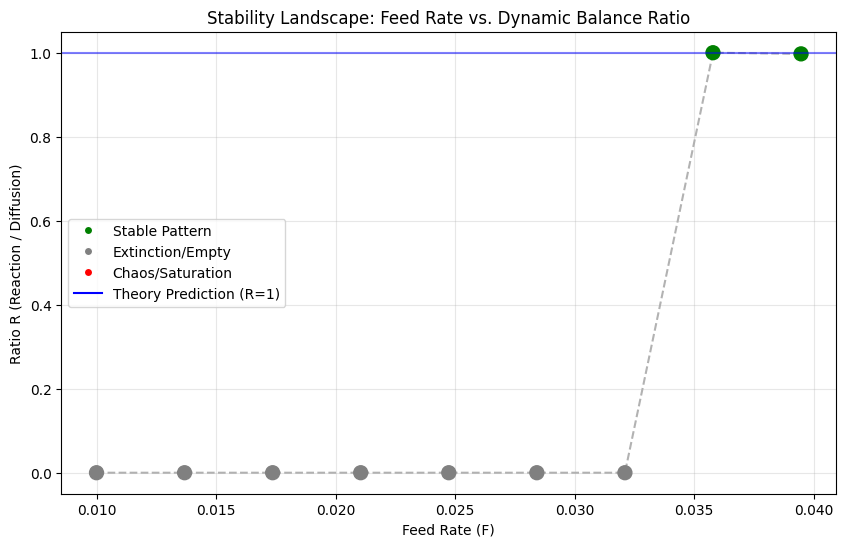

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from grayscott import GrayScott, laplacian

def run_sweep():
    # Range of F to sweep (covers extinction, spots, stripes, and chaos)
    # Pearson classification typically: 
    # F < 0.01: Extinction
    # 0.02 < F < 0.04: Spots/Stripes (Stable)
    # F > 0.06: Chaos/Saturation
    f_values = np.linspace(0.01, 0.08, 20)
    k_fixed = 0.062
    
    ratios = []
    stability_regimes = []

    print(f"Starting Parameter Sweep over F (k={k_fixed})...")

    for f in tqdm(f_values):
        # Initialize model
        gs = GrayScott(F=f, k=k_fixed, N=64)
        
        # Run to equilibrium (or max steps)
        # We need enough steps for the pattern to emerge
        for _ in range(2000):
            gs.step()
        
        # Measure Forces at steady state
        U_view = gs.U[1:-1, 1:-1]
        V_view = gs.V[1:-1, 1:-1]
        
        # Diffusion Force |D_v * Lap_v|
        # (Using V usually gives cleaner structure metric for spots)
        lap_v = laplacian(gs.V, gs.dx)
        diff_force = np.mean(np.abs(gs.D_v * lap_v))
        
        # Reaction Force |uv^2 - (F+k)v|
        uv2 = U_view * V_view**2
        react_force = np.mean(np.abs(uv2 - (gs.F + gs.k) * V_view))
        
        # Calculate Ratio
        if diff_force < 1e-9: # Avoid division by zero in extinction
            ratio = 0.0
        else:
            ratio = react_force / diff_force
            
        ratios.append(ratio)
        
        # Simple heuristic for regime classification based on V concentration
        max_v = np.max(V_view)
        if max_v < 0.05:
            stability_regimes.append("Extinction")
        elif max_v > 0.1:
            stability_regimes.append("Pattern")
        else:
            stability_regimes.append("Unstable")

    return f_values, ratios, stability_regimes

def plot_sweep(f_values, ratios, regimes):
    plt.figure(figsize=(10, 6))
    
    # Color code the points
    colors = {'Extinction': 'gray', 'Pattern': 'green', 'Unstable': 'red'}
    c_map = [colors[r] for r in regimes]
    
    plt.scatter(f_values, ratios, c=c_map, s=100, zorder=2)
    plt.plot(f_values, ratios, 'k--', alpha=0.3, zorder=1)
    
    # Highlight the "Golden Ratio" line
    plt.axhline(y=1.0, color='blue', linestyle='-', alpha=0.5, label='Perfect Balance (R=1)')
    
    plt.title("Stability Landscape: Feed Rate vs. Dynamic Balance Ratio")
    plt.xlabel("Feed Rate (F)")
    plt.ylabel("Ratio R (Reaction / Diffusion)")
    plt.grid(True, alpha=0.3)
    
    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Stable Pattern'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', label='Extinction/Empty'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Chaos/Saturation'),
        Line2D([0], [0], color='blue', label='Theory Prediction (R=1)')
    ]
    plt.legend(handles=legend_elements)
    
    plt.savefig("parameter_sweep.png")
    print("Saved parameter_sweep.png")
    plt.show()

f, r, reg = run_sweep()
plot_sweep(f, r, reg)

In [21]:
def run_rd_exp(history):
    print("=== RD Analysis ===")
    
    diff_forces, react_forces = [], []
    dx = history["dx"]
    F = history["F"]
    k = history["k"]
    D_u = history["D_u"]
    D_v = history["D_v"]

    for t in range(len(history["V"])):
        U_t = history["U"][t]
        V_t = history["V"][t]

        lap_V = torch.tensor(laplacian(V_t, dx))
        f_diff = torch.mean(torch.linalg.norm(D_v * lap_V)).item()

        uv2 = U_t * V_t**2
        reaction_V = torch.tensor(uv2 - (F + k) * V_t)
        f_react = torch.mean(torch.linalg.norm(reaction_V)).item()

        diff_forces.append(f_diff)
        react_forces.append(f_react)

    # Metrics: Mean magnitude per cell
    m_diff = np.mean(diff_forces)
    m_react = np.mean(react_forces)
    
    print(f"RD Diffusion Force: {m_diff}")
    print(f"RD Reaction Force:  {m_react}")
    
    return m_diff, m_react, diff_forces, react_forces


def run_lstm_exp(history):
    print("=== LSTM Analysis ===")

    diff_forces, react_forces = [], []

    for t in range(len(history["input"])):
        i_t = history["input"][t]
        f_t = history["forget"][t]
        C_tilde = history["cell_update"][t]
        C_t = history["cell"][t]
        C_prev = history["cell"][t-1] if t > 0 else torch.zeros_like(C_t)
                
        # Reaction (Restoring Force): 
        # The force pushing the state to the new value (oscillation update)
        # Magnitude of new information injected: |i_t * C_tilde|
        f_react = torch.mean(torch.linalg.norm(i_t * C_tilde)).item()
        
        # Diffusion (Decay/Stabilization):
        # The force eroding the previous state (forgetting)
        # Magnitude of information removed: |(1 - f_t) * C_prev|
        f_diff = torch.mean(torch.linalg.norm((1 - f_t) * C_prev)).item()
        
        diff_forces.append(f_diff)
        react_forces.append(f_react)
            
    m_diff = np.mean(diff_forces)
    m_react = np.mean(react_forces)

    print(f"LSTM Diffusion Force: {m_diff}")
    print(f"LSTM Reaction Force:  {m_react}")
    
    return m_diff, m_react, diff_forces, react_forces

def run_ddpm_exp(history):
    print("=== DDPM Analysis ===")
    drift_forces = []
    noise_forces = []

    for t in range(len(history_ddpm["time"])):
        drift_vector = torch.tensor(history["drift"][t])
        diffusion_term = torch.tensor(history["diffusion"][t])

        f_react = torch.mean(torch.linalg.norm(drift_vector)).item()
        drift_forces.append(f_react)

        f_diff = torch.mean(torch.linalg.norm(diffusion_term)).item()
        noise_forces.append(f_diff)

    m_diff = np.mean(noise_forces)
    m_react = np.mean(drift_forces)
    
    print(f"DDPM Noise Force (Diff):  {m_diff}")
    print(f"DDPM Drift Force (React): {m_react}")
    
    return m_diff, m_react, noise_forces, drift_forces


In [22]:
rd_diff_mean_list, rd_react_mean_list, rd_diff_history_list, rd_react_history_list = [], [], [], []
lstm_diff_mean_list, lstm_react_mean_list, lstm_diff_history_list, lstm_react_history_list = [], [], [], []
ddpm_diff_mean_list, ddpm_react_mean_list, ddpm_diff_history_list, ddpm_react_history_list = [], [], [], []

n_simul = 1

In [30]:
F_list = np.linspace(0.029, 0.0545, n_simul) # spots to strides
k = 0.062
D_u = 1e-5
D_v = 0.5e-5
T_max = 15000
for f in F_list:
    gs = GrayScott(F=f, k=k,D_u=D_u, D_v=D_v, N=256)
    U, V, V_history, stability_time, diff_history_rd, history_rd = gs.forward(0,T_max, frame=True, data=False)
    rd_diff, rd_react, rd_diff_list, rd_react_list = run_rd_exp(history_rd)
    rd_diff_mean_list.append(rd_diff)
    rd_react_mean_list.append(rd_react)
    rd_diff_history_list.append(rd_diff_list)
    rd_react_history_list.append(rd_react_list)

F=0.029, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:18<00:00, 652.00it/s]


=== RD Analysis ===
RD Diffusion Force: 0.820723685195331
RD Reaction Force:  0.8254040885184547


F=0.032, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:18<00:00, 653.11it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8914831710659177
RD Reaction Force:  0.8983608030480272


F=0.035, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:21<00:00, 565.11it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8781697770519791
RD Reaction Force:  0.8858556924138876


F=0.037, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:25<00:00, 491.04it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8574540815839606
RD Reaction Force:  0.86502761411802


F=0.040, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:22<00:00, 555.37it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8274577922986593
RD Reaction Force:  0.835218871655766


F=0.043, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:23<00:00, 524.17it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8476364809513605
RD Reaction Force:  0.8543774265073781


F=0.046, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:17<00:00, 685.57it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8642380840393146
RD Reaction Force:  0.8714289798571265


F=0.049, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:21<00:00, 571.76it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8710179968888933
RD Reaction Force:  0.8791604069960665


F=0.052, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:22<00:00, 550.40it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8896492700028782
RD Reaction Force:  0.8971205295900038


F=0.054, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:20<00:00, 602.55it/s]


=== RD Analysis ===
RD Diffusion Force: 0.9091175137204179
RD Reaction Force:  0.9164204150165047


In [88]:
f = 0.029
k = 0.062
D_u = 1e-5
D_v = 0.5e-5
T_max = 15000
gs = GrayScott(F=f, k=k,D_u=D_u, D_v=D_v, N=256)
U, V, V_history, stability_time, diff_history_rd, history_rd = gs.forward(0,T_max, frame=True, data=False)
rd_diff, rd_react, rd_diff_list, rd_react_list = run_rd_exp(history_rd)
rd_diff_mean_list.append(rd_diff)
rd_react_mean_list.append(rd_react)
rd_diff_history_list.append(rd_diff_list)
rd_react_history_list.append(rd_react_list)

F=0.029, k=0.062: 100%|█████████████████████████████████████▉| 12280/12288 [00:24<00:00, 501.99it/s]


=== RD Analysis ===
RD Diffusion Force: 0.8101378710074499
RD Reaction Force:  0.8157610325108726


In [95]:
for _ in range(10):
    rand_index = random.randint(0, n_samples)
    seed_sample = lstm_data[rand_index]
    seed_sample_random = torch.randn(seq_len, 1)
    generated, history_lstm_gen = lstm_model.generate_sequence(seed_sample, future_steps=future_steps)
    lstm_diff, lstm_react, lstm_diff_list, lstm_react_list = run_lstm_exp(history_lstm_gen)
    lstm_diff_mean_list.append(lstm_diff)
    lstm_react_mean_list.append(lstm_react)
    lstm_diff_history_list.append(lstm_diff_list)
    lstm_react_history_list.append(lstm_react_list)

=== LSTM Analysis ===
LSTM Diffusion Force: 1.472827831007783
LSTM Reaction Force:  1.4258184262684412
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4211077768551676
LSTM Reaction Force:  1.4217172751301212
=== LSTM Analysis ===
LSTM Diffusion Force: 1.444661829854014
LSTM Reaction Force:  1.3891670085433732
=== LSTM Analysis ===
LSTM Diffusion Force: 1.5273553184548716
LSTM Reaction Force:  1.4532602820778848
=== LSTM Analysis ===
LSTM Diffusion Force: 1.3396398864294354
LSTM Reaction Force:  1.315175279489436
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4455075582914185
LSTM Reaction Force:  1.453604279454788
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4420300469661416
LSTM Reaction Force:  1.3994724977584112
=== LSTM Analysis ===
LSTM Diffusion Force: 1.5665590556940638
LSTM Reaction Force:  1.4882011628688727
=== LSTM Analysis ===
LSTM Diffusion Force: 1.472314193956834
LSTM Reaction Force:  1.414210977037449
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4334563362717927
LSTM Re

Starting inference on cpu with 1000 steps...


999it [00:51, 19.36it/s]


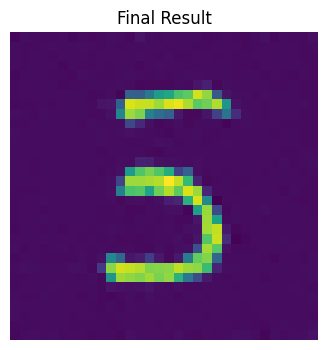

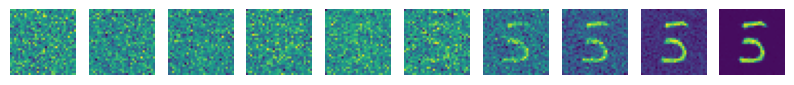

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0295831906497477
DDPM Drift Force (React): 0.21374263897538184


In [85]:
for _ in range(n_simul):
    history_ddpm = inference(ddpm_model=ddpm_model, checkpoint_path=None, num_time_steps=n_T)
    ddpm_diff, ddpm_react, ddpm_diff_list, ddpm_react_list = run_ddpm_exp(history_ddpm)
    ddpm_diff_mean_list.append(ddpm_diff)
    ddpm_react_mean_list.append(ddpm_react)
    ddpm_diff_history_list.append(ddpm_diff_list)
    ddpm_react_history_list.append(ddpm_react_list)

In [94]:
# Calculate Ratios
rd_ratio = rd_react / (rd_diff if rd_diff != 0 else rd_diff + 1e-10)
lstm_ratio = lstm_react / (lstm_diff if lstm_diff != 0 else lstm_diff + 1e-10)
ddpm_ratio = ddpm_react / (ddpm_diff if ddpm_diff != 0 else ddpm_diff + 1e-10)

print(f"{'Model':<20} | {'M_diff (Decay)':<18} | {'M_react (Growth)':<18} | {'Ratio (react/diff)':<15}")
print("-" * 80)
print(f"{'Gray-Scott (RD)':<20} | {rd_diff:<18.8f} | {rd_react:<18.8f} | {rd_ratio:<15.8f}")
print(f"{'LSTM':<20} | {lstm_diff:<18.8f} | {lstm_react:<18.8f} | {lstm_ratio:<15.8f}")
print(f"{'DDPM':<20} | {ddpm_diff:<18.8f} | {ddpm_react:<18.8f} | {ddpm_ratio:<15.8f}")

Model                | M_diff (Decay)     | M_react (Growth)   | Ratio (react/diff)
--------------------------------------------------------------------------------
Gray-Scott (RD)      | 0.81013787         | 0.81576103         | 1.00694099     
LSTM                 | 1.55586204         | 1.48916310         | 0.95713056     
DDPM                 | 3.02958319         | 0.21374264         | 0.07055183     


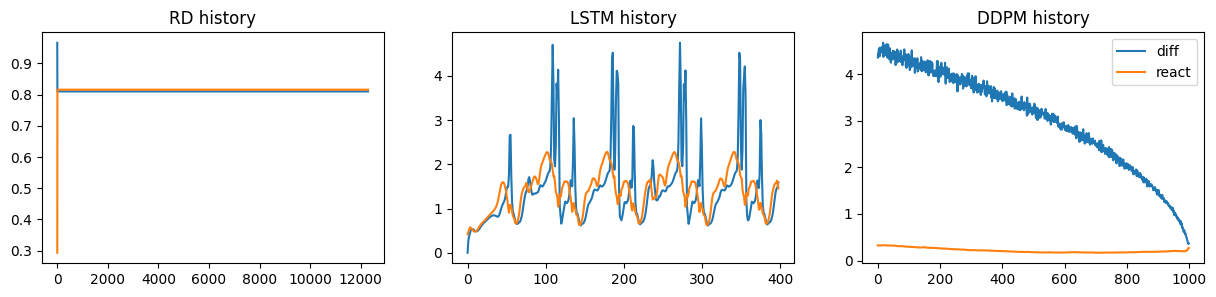

In [96]:
fig, ax = plt.subplots(1,3, figsize=(15,3))

rand_index = random.randint(0,200)
ax[0].plot(rd_diff_list, label="diff")
ax[0].plot(rd_react_list, label="react")
ax[0].set_title("RD history")

ax[1].plot(lstm_diff_list, label="diff")
ax[1].plot(lstm_react_list, label="react")
ax[1].set_title("LSTM history")

ax[2].plot(ddpm_diff_list, label="diff")
ax[2].plot(ddpm_react_list, label="react")
ax[2].set_title("DDPM history")

plt.legend()
plt.show()

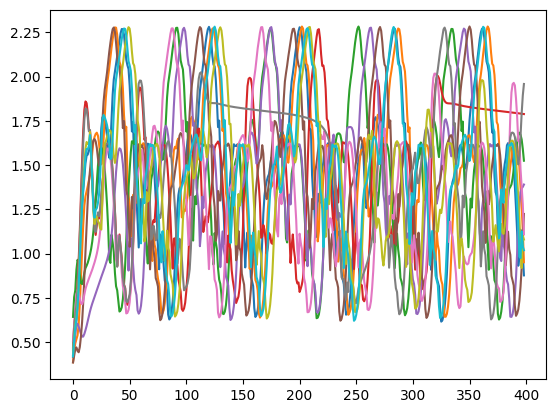

In [112]:
for i in range(10):
    plt.plot(lstm_react_history_list[i])

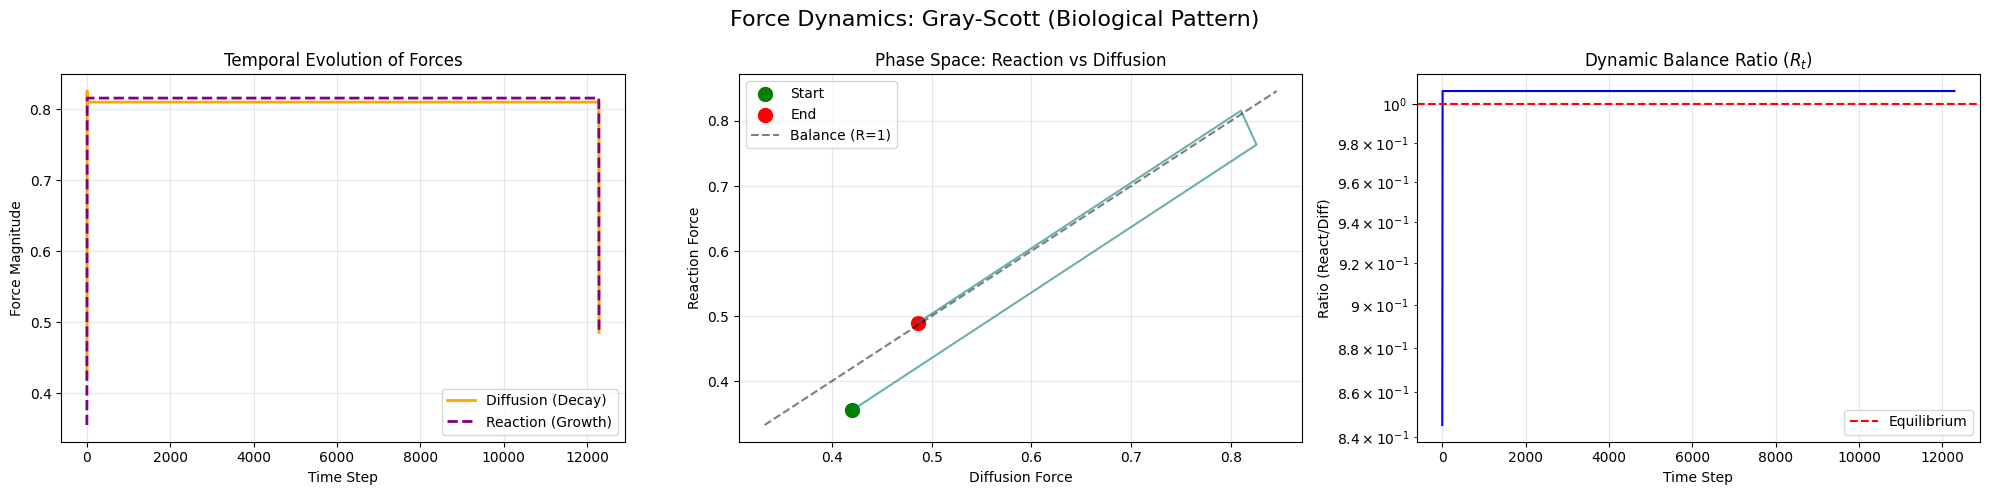

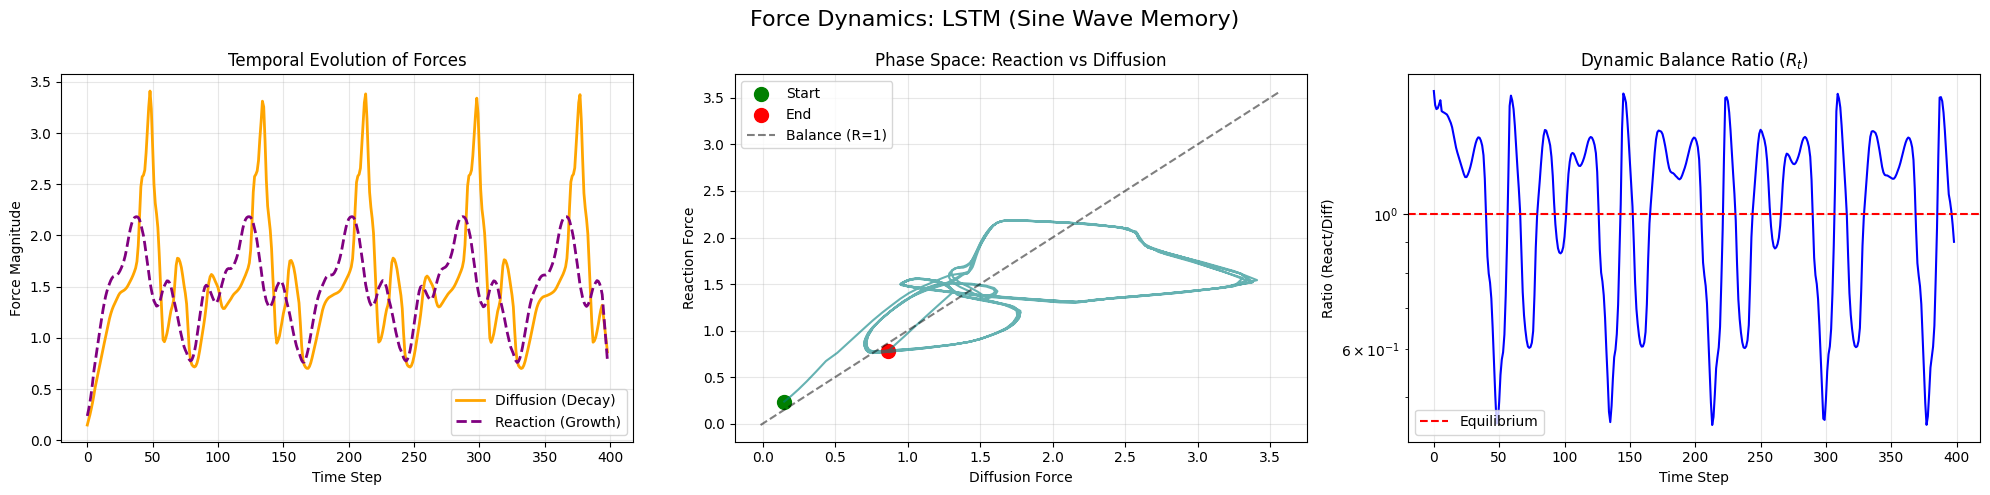

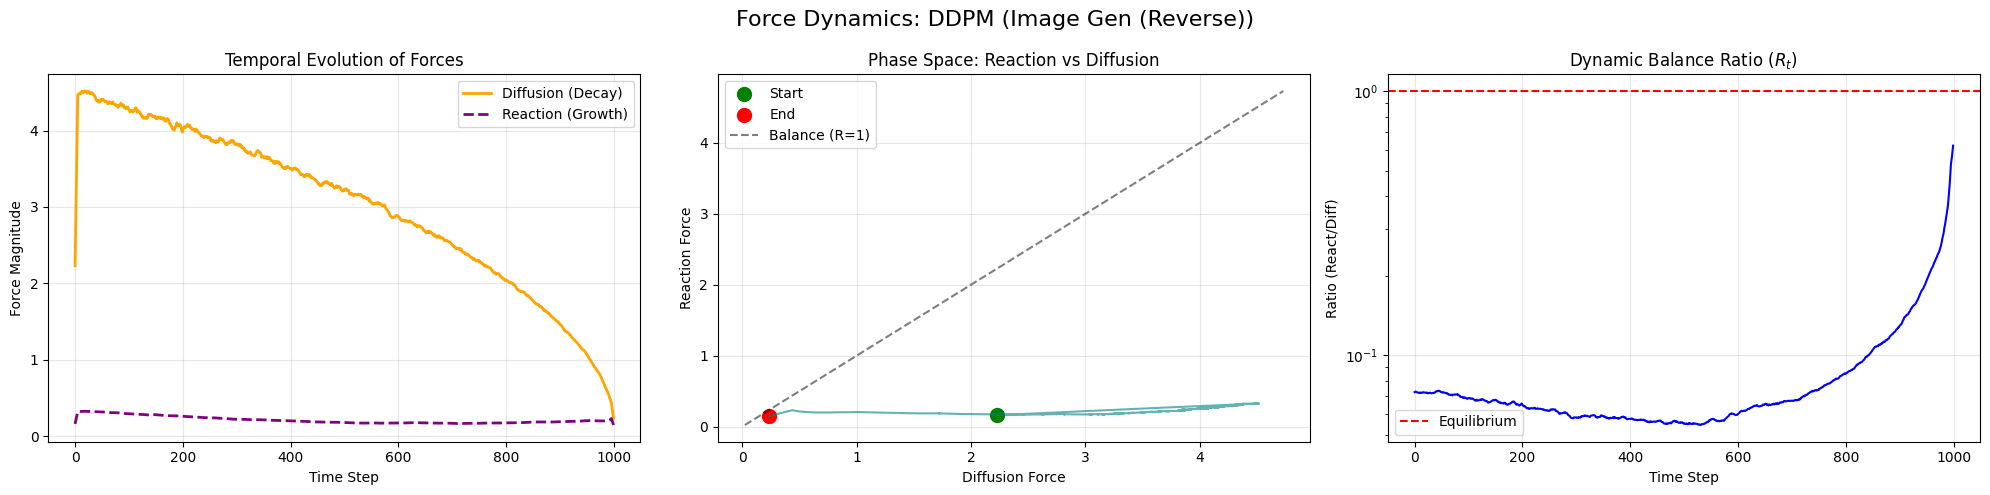

In [93]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_forces(model_name, diff_forces, react_forces, task_type="Static"):
    """
    Generates a 3-panel analysis dashboard for a single model.
    """
    # Normalize time axis
    steps = np.arange(len(diff_forces))
    
    # Smooth data for cleaner plotting (optional moving average)
    def smooth(y, box_pts=10):
        if len(y) < 20: return y
        box = np.ones(box_pts)/box_pts
        return np.convolve(y, box, mode='same')

    d_smooth = smooth(np.array(diff_forces))
    r_smooth = smooth(np.array(react_forces))

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"Force Dynamics: {model_name} ({task_type})", fontsize=16)

    # --- Plot 1: Temporal Evolution (The "Battle") ---
    # Shows how forces compete over time
    axes[0].plot(steps, d_smooth, label='Diffusion (Decay)', color='orange', linewidth=2)
    axes[0].plot(steps, r_smooth, label='Reaction (Growth)', color='purple', linewidth=2, linestyle='--')
    axes[0].set_title("Temporal Evolution of Forces")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("Force Magnitude")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # --- Plot 2: Phase Space (The "Attractor") ---
    # Shows the system's stability signature
    axes[1].plot(d_smooth, r_smooth, color='teal', alpha=0.6)
    # Mark start and end
    axes[1].scatter(d_smooth[0], r_smooth[0], c='green', label='Start', s=100)
    axes[1].scatter(d_smooth[-1], r_smooth[-1], c='red', label='End', s=100)
    # Add y=x line (Perfect Balance)
    lims = [
        np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
        np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
    ]
    axes[1].plot(lims, lims, 'k--', alpha=0.5, label='Balance (R=1)')
    axes[1].set_title("Phase Space: Reaction vs Diffusion")
    axes[1].set_xlabel("Diffusion Force")
    axes[1].set_ylabel("Reaction Force")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # --- Plot 3: Balance Ratio Evolution ---
    # Shows how the "Goldilocks" ratio changes
    # Avoid div by zero
    ratio = r_smooth / (d_smooth + 1e-9)
    axes[2].plot(steps, ratio, color='blue')
    axes[2].axhline(y=1.0, color='r', linestyle='--', label='Equilibrium')
    axes[2].set_title("Dynamic Balance Ratio ($R_t$)")
    axes[2].set_xlabel("Time Step")
    axes[2].set_ylabel("Ratio (React/Diff)")
    axes[2].set_yscale('log') # Log scale often reveals more details
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example Usage (Replace with your actual data variables)
analyze_forces("Gray-Scott", rd_diff_list, rd_react_list, "Biological Pattern")
analyze_forces("LSTM", lstm_diff_list, lstm_react_list, "Sine Wave Memory")
analyze_forces("DDPM", ddpm_diff_list, ddpm_react_list, "Image Gen (Reverse)")

--- Starting Statistical Validation (N=10) ---


  0%|          | 0/10 [00:00<?, ?it/s]

=== RD Analysis ===


 10%|█         | 1/10 [00:14<02:12, 14.68s/it]

RD Diffusion Force: 0.8101378710074499
RD Reaction Force:  0.8157610325108726
=== LSTM Analysis ===
LSTM Diffusion Force: 32.61143894195557
LSTM Reaction Force:  35.50476444244385
=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0295831906497477
DDPM Drift Force (React): 0.21374263897538184
=== RD Analysis ===


 20%|██        | 2/10 [00:24<01:32, 11.55s/it]

RD Diffusion Force: 0.8101378710074499
RD Reaction Force:  0.8157610325108726
=== LSTM Analysis ===
LSTM Diffusion Force: 32.61143894195557
LSTM Reaction Force:  35.50476444244385
=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0295831906497477
DDPM Drift Force (React): 0.21374263897538184
=== RD Analysis ===


 30%|███       | 3/10 [00:35<01:19, 11.31s/it]

RD Diffusion Force: 0.8101378710074499
RD Reaction Force:  0.8157610325108726
=== LSTM Analysis ===
LSTM Diffusion Force: 32.61143894195557
LSTM Reaction Force:  35.50476444244385
=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0295831906497477
DDPM Drift Force (React): 0.21374263897538184
=== RD Analysis ===


 40%|████      | 4/10 [00:46<01:06, 11.16s/it]

RD Diffusion Force: 0.8101378710074499
RD Reaction Force:  0.8157610325108726
=== LSTM Analysis ===
LSTM Diffusion Force: 32.61143894195557
LSTM Reaction Force:  35.50476444244385
=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0295831906497477
DDPM Drift Force (React): 0.21374263897538184
=== RD Analysis ===


 50%|█████     | 5/10 [00:59<01:00, 12.00s/it]

RD Diffusion Force: 0.8101378710074499
RD Reaction Force:  0.8157610325108726
=== LSTM Analysis ===
LSTM Diffusion Force: 32.61143894195557
LSTM Reaction Force:  35.50476444244385
=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0295831906497477
DDPM Drift Force (React): 0.21374263897538184
=== RD Analysis ===


 60%|██████    | 6/10 [01:15<00:53, 13.49s/it]

RD Diffusion Force: 0.8101378710074499
RD Reaction Force:  0.8157610325108726
=== LSTM Analysis ===
LSTM Diffusion Force: 32.61143894195557
LSTM Reaction Force:  35.50476444244385
=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0295831906497477
DDPM Drift Force (React): 0.21374263897538184
=== RD Analysis ===


 70%|███████   | 7/10 [01:25<00:36, 12.10s/it]

RD Diffusion Force: 0.8101378710074499
RD Reaction Force:  0.8157610325108726
=== LSTM Analysis ===
LSTM Diffusion Force: 32.61143894195557
LSTM Reaction Force:  35.50476444244385
=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0295831906497477
DDPM Drift Force (React): 0.21374263897538184
=== RD Analysis ===


 80%|████████  | 8/10 [01:35<00:23, 11.70s/it]

RD Diffusion Force: 0.8101378710074499
RD Reaction Force:  0.8157610325108726
=== LSTM Analysis ===
LSTM Diffusion Force: 32.61143894195557
LSTM Reaction Force:  35.50476444244385
=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0295831906497477
DDPM Drift Force (React): 0.21374263897538184
=== RD Analysis ===


 90%|█████████ | 9/10 [01:45<00:10, 10.99s/it]

RD Diffusion Force: 0.8101378710074499
RD Reaction Force:  0.8157610325108726
=== LSTM Analysis ===
LSTM Diffusion Force: 32.61143894195557
LSTM Reaction Force:  35.50476444244385
=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0295831906497477
DDPM Drift Force (React): 0.21374263897538184
=== RD Analysis ===


100%|██████████| 10/10 [01:54<00:00, 11.47s/it]

RD Diffusion Force: 0.8101378710074499
RD Reaction Force:  0.8157610325108726
=== LSTM Analysis ===
LSTM Diffusion Force: 32.61143894195557
LSTM Reaction Force:  35.50476444244385
=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0295831906497477
DDPM Drift Force (React): 0.21374263897538184

=== Final Statistical Results ===
RD: Ratio = 1.0069 ± 0.0000
LSTM: Ratio = 1.0887 ± 0.0000
DDPM: Ratio = 0.0706 ± 0.0000


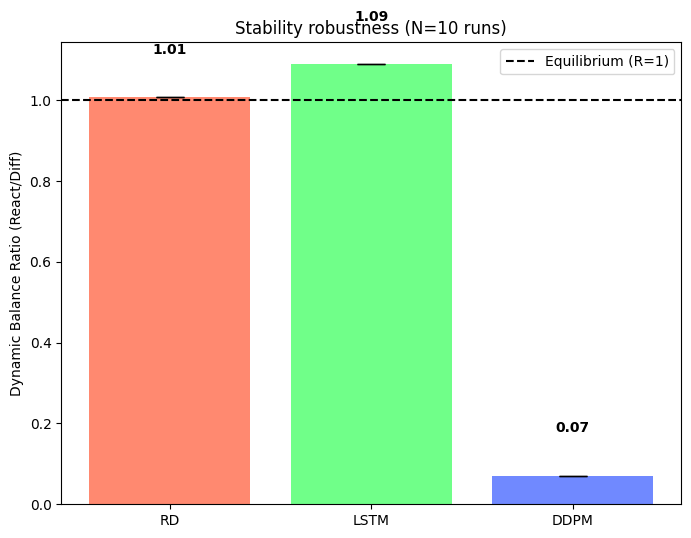

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def run_statistical_validation(n_runs=10):
    print(f"--- Starting Statistical Validation (N={n_runs}) ---")
    
    # Store results
    results = {
        "RD":   {"ratios": [], "diffs": [], "reacts": []},
        "LSTM": {"ratios": [], "diffs": [], "reacts": []},
        "DDPM": {"ratios": [], "diffs": [], "reacts": []}
    }
    
    for i in tqdm(range(n_runs)):
        # 1. Run RD
        # (Replace with your actual function call, e.g., run_rd_exp())
        # Ensure your functions return just the scalar values for this loop
        rd_diff, rd_react, _, _ = run_rd_exp(history_rd) 
        results["RD"]["diffs"].append(rd_diff)
        results["RD"]["reacts"].append(rd_react)
        results["RD"]["ratios"].append(rd_react / (rd_diff + 1e-9))
        
        # 2. Run LSTM
        # (Re-initialize and re-train model each time for full rigor!)
        lstm_diff, lstm_react, _, _ = run_lstm_exp(history_lstm)
        results["LSTM"]["diffs"].append(lstm_diff)
        results["LSTM"]["reacts"].append(lstm_react)
        results["LSTM"]["ratios"].append(lstm_react / (lstm_diff + 1e-9))
        
        # 3. Run DDPM
        # (Run inference on a new random noise tensor)
        ddpm_diff, ddpm_react, _, _ = run_ddpm_exp(history_ddpm)
        results["DDPM"]["diffs"].append(ddpm_diff)
        results["DDPM"]["reacts"].append(ddpm_react)
        results["DDPM"]["ratios"].append(ddpm_react / (ddpm_diff + 1e-9))
        
    return results

def plot_statistics(results):
    models = ["RD", "LSTM", "DDPM"]
    means = [np.mean(results[m]["ratios"]) for m in models]
    stds = [np.std(results[m]["ratios"]) for m in models]
    
    # Print numerical results
    print("\n=== Final Statistical Results ===")
    for m, mean, std in zip(models, means, stds):
        print(f"{m}: Ratio = {mean:.4f} ± {std:.4f}")

    # Plot
    plt.figure(figsize=(8, 6))
    bars = plt.bar(models, means, yerr=stds, capsize=10, 
                   color=['#FF5733', '#33FF57', '#3357FF'], alpha=0.7)
    
    plt.axhline(y=1.0, color='k', linestyle='--', label='Equilibrium (R=1)')
    plt.title("Stability robustness (N=10 runs)")
    plt.ylabel("Dynamic Balance Ratio (React/Diff)")
    plt.legend()
    
    # Add labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.show()

plot_statistics(run_statistical_validation())